# Hyperparameter optimisation

In this section, we cover the topic of `overfitting`. A folk theorem in asset management is that people are so afraid of overfitting that they tend to (massively) underfit. Or at least, that was the case. Today, better fitting models to extract as much information from a dataset has become a crucial skill. 

More precisely, `overfitting` a particular dataset provides a baseline for how well a system can learn (e.g. see the Recipe for Training Neural Nets by Andrej Karpathy). 

In [1]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os 
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from IPython.display import display, Image

import logging
logging.basicConfig(level=logging.CRITICAL)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from lightgbm.sklearn import LGBMRegressor

from skfin.plot import line, bar
from skfin.datasets import load_kf_returns
from skfin.mv_estimators import MeanVariance 
from skfin.backtesting import Backtester
from skfin.metrics import sharpe_ratio
from skfin.estimators import RidgeCV, MultiOutputRegressor, MLPRegressor

returns_data = load_kf_returns(cache_dir='data')
ret = returns_data['Monthly']['Average_Value_Weighted_Returns'][:'1999']

transform_X = lambda x: x.rolling(12).mean().fillna(0).values
transform_y = lambda x: x.shift(-1).values
features = transform_X(ret)
target = transform_y(ret)

In [2]:
from skfin.datasets import load_kf_returns
returns_data = load_kf_returns(cache_dir='data')

## Ridge CV

Another strategy is to use estimators that embed some form of cross-validation like `RidgeCV`.

K-fold cross validation is described as follows: 

Take a model with parameter $s$ (e.g. the Ridge with tuning parameter `alpha`): 

1. divide the data into $K$ roughly equal parts ($K = 5$ or $K = 10$)

1. for each $k \in \{1, 2,..., K\}$ fit the model with parameter $s$ to the other $K-1$ parts and compute its error $E_k(s)$  in predicting the $k$-th part.

1. the overall cross-validation error is then $CV(s)= \frac{1}{K} \sum_{k=1}^K E_k(s)$. 

1. do this for many values of $s$ and choose the value of s that minimize $CV (s)$

In [3]:
alphas = np.exp(np.arange(np.log(10),np.log(10001), (np.log(10000) - np.log(10))/10))

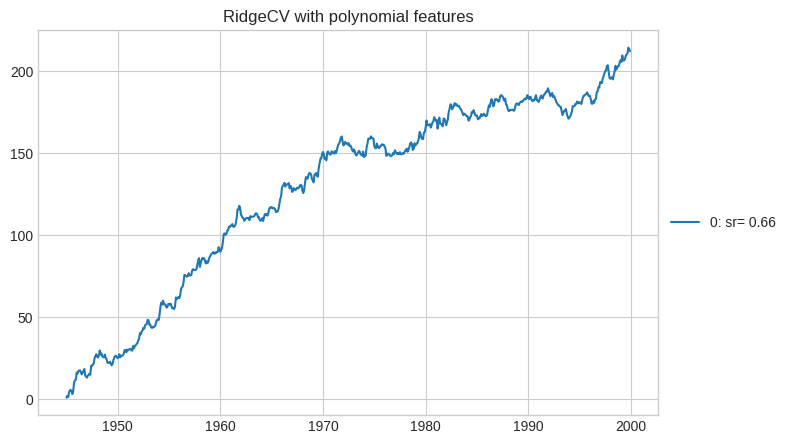

In [4]:
estimator = make_pipeline(StandardScaler(with_mean=False), 
                          PolynomialFeatures(degree=2), 
                          RidgeCV(alphas=alphas, cv=5), 
                          MeanVariance())

m = Backtester(estimator, ret).train(features, target)
line(m.pnl_, cumsum=True, title='RidgeCV with polynomial features')

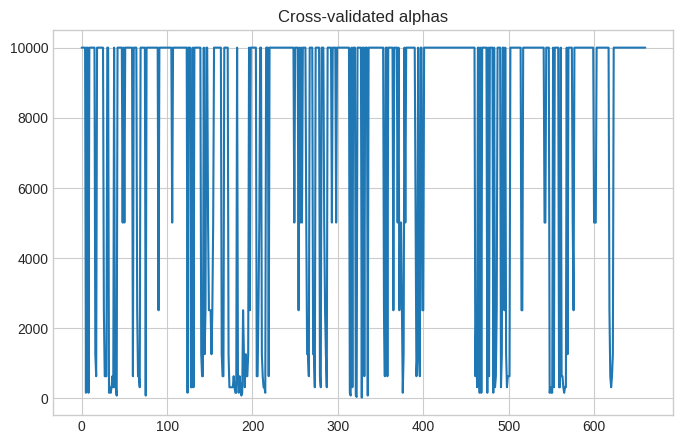

In [5]:
line(pd.Series([m[2].alpha_ for m in m.estimators_]), title='Cross-validated alphas', legend=False)

In this example, the fitted alphas over rolling windows are not very stable (probably given the small rolling windows used here).

## Random parameter search for Lightgbm

https://lightgbm.readthedocs.io/en/latest/Parameters.html#learning-control-parameters

We first compute a `Lightgbm` benchmark with the fixed baseline parameters used in a previous section. 

In [6]:
estimator = make_pipeline(MultiOutputRegressor(LGBMRegressor(min_child_samples=5, 
                                                             n_estimators=25, 
                                                             n_jobs=1)), 
                          MeanVariance())

pnl_lgb = {'fixed_params':  Backtester(estimator, ret).train(features, target).pnl_ }

We now do a search with random parameters drawn from predetermined distribution: 

- the random parameter generators come from the `scipy.stats` module -- in particular `randint`, `uniform` and `loguniform`.
- we use the `scikit-learn` function `ParameterSampler` as wrapper. 

Setup: 

- the objective is to maximize the sharpe ratio over the early period 1945 to 1972 (as the `train` period). 
- the evaluation is the performance of the backtest over the 1972-to-2000 period (as the `test` period). 

In [7]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint, uniform, loguniform

In [8]:
n_iter = 50 
start_date = "1945-01-01"
end_date = "1972-04-01"
param_distributions = {"max_depth": randint(3, 10),
                       "num_leaves": randint(2, 2**8), 
                       "n_estimators": randint(5, 50), 
                       "min_split_gain": uniform(0, 1.0), 
                       "min_child_samples": randint(1, 5), 
                       "reg_lambda": loguniform(1e-8, 1.0), 
                       "reg_alpha": loguniform(1e-8, 1.0)
                      }

In [9]:
force_recompute = False 
cache_dir = Path(os.getcwd()) / "cache"
if not cache_dir.is_dir(): 
    os.makedirs(cache_dir)

fname = cache_dir /'hpo_lgb.parquet'
if (force_recompute)|(not fname.exists()):
    results_ = {}
    for i, prm in enumerate(ParameterSampler(param_distributions=param_distributions, n_iter=n_iter)): 
        estimator = make_pipeline(MultiOutputRegressor(LGBMRegressor(n_jobs=1, **prm)), 
                                  MeanVariance())
        pnl_ = Backtester(estimator, ret, end_date=end_date).train(features, target).pnl_
        prm.update({'sr': pnl_.pipe(sharpe_ratio)})
        results_[i] = pd.Series(prm)
    results = pd.DataFrame.from_dict(results_, orient='index').sort_values('sr')
    results.to_parquet(fname)
else: 
    results = pd.read_parquet(fname)

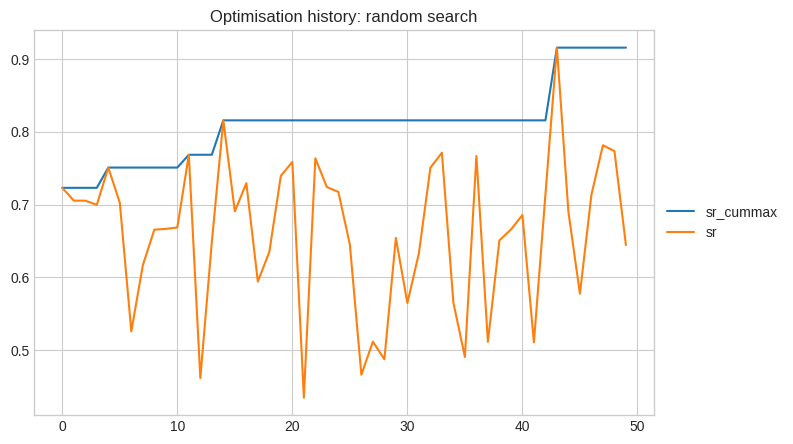

In [10]:
df = results.sort_index()[['sr']].assign(sr_cummax = lambda x: x.sr.cummax())
line(df, title='Optimisation history: random search')

Using the sharpe ratio statistics presented in a previous section, we can compute a standard error around the maximum sharpe ratio: 

In [11]:
sr_max = results.iloc[-1]['sr'] / np.sqrt(12)
sr_std = np.sqrt(12) * np.sqrt((1 + .5 * sr_max **2)/ len(ret[start_date:end_date])) 
sr_range = results['sr'].pipe(lambda x: x.max()-x.min())
print(f'The sharpe ratio standard deviation at the maximum sharpe ratio (of {sr_max * np.sqrt(12):.2f}) is {sr_std:.2f}')

print(f'The range of the sharpe ratios in the random search is {sr_range:.2f}')

The sharpe ratio standard deviation at the maximum sharpe ratio (of 0.92) is 0.19
The range of the sharpe ratios in the random search is 0.48


In [12]:
best_params = results.drop('sr', axis=1).iloc[-1].to_dict()
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params

{'max_depth': 3,
 'min_child_samples': 1,
 'min_split_gain': 0.32357152509471354,
 'n_estimators': 28,
 'num_leaves': 158,
 'reg_alpha': 4.502375813615874e-05,
 'reg_lambda': 5.407213948451059e-06}

In [13]:
estimator = make_pipeline(MultiOutputRegressor(LGBMRegressor(n_jobs=1, **best_params)), 
                          MeanVariance())
pnl_lgb['best_params'] = Backtester(estimator, ret).train(features, target).pnl_

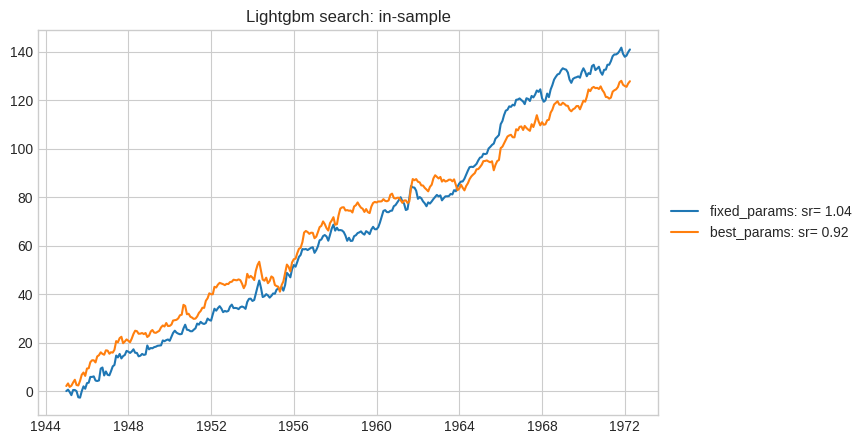

In [14]:
line({k: v.loc[start_date:end_date] for k, v in pnl_lgb.items()}, cumsum=True, title='Lightgbm search: in-sample')

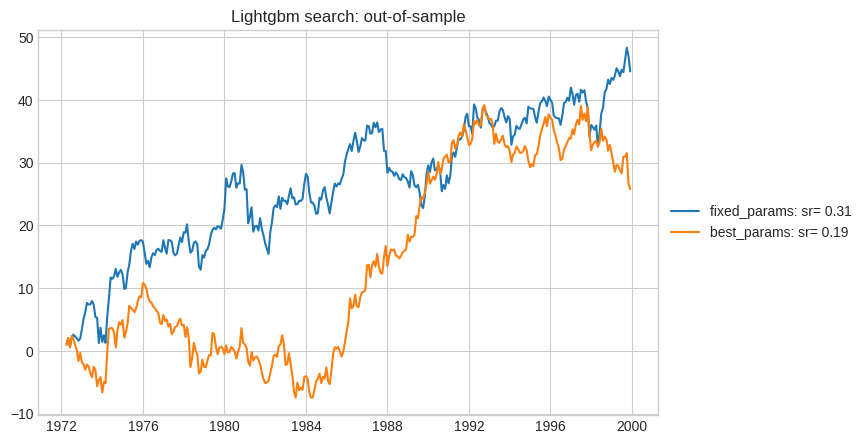

In [15]:
line({k: v.loc[end_date:] for k, v in pnl_lgb.items()}, cumsum=True, title='Lightgbm search: out-of-sample')

What are the parameters that are correlated with the sharpe ratio? 

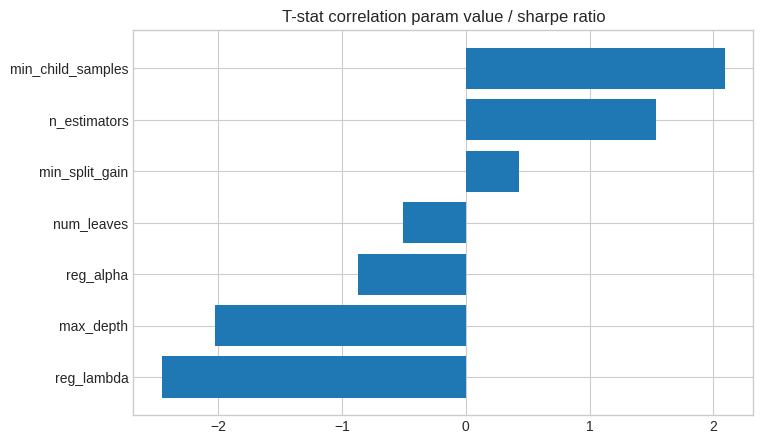

In [16]:
bar(results.corr()['sr'].mul(np.sqrt(n_iter)).drop('sr'), 
    title='T-stat correlation param value / sharpe ratio', horizontal=True)

To assess more precisely the impact of parameters on the sharpe ratio, we run a regression. 

In [17]:
from statsmodels import api
m = api.OLS(results["sr"], api.add_constant(results.drop('sr', axis=1))).fit()

In [18]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     2.224
Date:                Sat, 22 Apr 2023   Prob (F-statistic):             0.0513
Time:                        10:40:57   Log-Likelihood:                 50.580
No. Observations:                  50   AIC:                            -85.16
Df Residuals:                      42   BIC:                            -69.86
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6384      0.071      8.968      0.000       0.495       0.782
max_depth            -0.0125      0.007     -1.691      0.098      -0.027       0.002
min_child_samples     0.0278      0.014      2.044      0.047       0.000       0.055
min_split_gain        0.0531      0.046      1.143      0.260      -0.041       0.147
n_estimators          0.0006      0.001      0.562      0.577      -0.002       0.003
num_leaves           -0.0001      0.000     -0.688      0.495      -0.001       0.000
reg_alpha             0.0235      0.080      0.294      0.770      -0.138       0.185
reg_lambda           -0.1893      0.119     -1.591      0.119      -0.429       0.051
==============================================================================
Omnibus:                        3.086   Durbin-Watson:                   0.604
Prob(Omnibus):                  0.214   Jarque-Bera (JB):                2.221
Skew:                           0.268   Prob(JB):                        0.329
Kurtosis:                       3.883   Cond. No.                     1.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""